### This notebook is dedicated to investigating different methods applying TWSA from GRACE and GRACE-FO to obtain the time derivatives of TWSA. The results will be used in monitoring extreme events such as floods and droughts in the Greater Horn of Africa region.
Author: S. Karimi Feb 2024 (s.karimi@utwente.nl)

# Read data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import xarray as xr 
import shxarray
import numpy as np
import matplotlib.pyplot as plt

from common.config import read_config

In [3]:
conf=read_config()
datadir=conf["dataroot"]

In [4]:
tws_sh=os.path.join(datadir,conf["nctws"])
dtws=xr.open_dataset(tws_sh)
dtws=dtws.sh.build_nmindex()
display(dtws)
ncbasins=os.path.join(datadir,conf["ncbasin"])
dsbasins_sh=xr.open_dataset(ncbasins).sh.truncate(nmax=96)
dsbasins_sh=dsbasins_sh.sh.build_nmindex()

<xarray.Dataset> Size: 18MB
Dimensions:  (time: 230, nm: 9408)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-05-15T12:00:00 ... 2024-04-15T12:...
  * nm       (nm) object 75kB MultiIndex
  * n        (nm) int64 75kB 1 1 1 2 2 2 2 2 3 3 ... 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 75kB 0 1 -1 0 1 -1 2 -2 ... 93 -93 94 -94 95 -95 96 -96
Data variables:
    tws      (time, nm) float64 17MB ...

In [5]:
shxengine='shtns'
dsbasinav = dtws.tws.sh.basinav(dsbasins_sh.basins, filtername="Gauss300", leakage_corr="scale", engine=shxengine).compute()

In [6]:
dsbasinav

<xarray.DataArray (name: 124, time: 230)> Size: 228kB
array([[-0.20027045, -0.00640688,  0.03289448, ...,  0.01128598,
        -0.02800967, -0.03599911],
       [-0.04775474, -0.04042144, -0.02760242, ...,  0.14116344,
         0.06624608,  0.06618412],
       [ 0.0473928 , -0.02228967, -0.03312914, ...,  0.14569709,
         0.13447473,  0.19577374],
       ...,
       [ 0.07811495, -0.0167212 , -0.06976785, ..., -0.03255849,
        -0.00170751, -0.02095721],
       [ 0.00287876, -0.01034941, -0.00861322, ...,  0.0194746 ,
         0.00522456, -0.01327456],
       [-0.1150695 , -0.04920286,  0.00611945, ...,  0.05741331,
         0.07323108,  0.03424164]])
Coordinates:
  * name     (name) <U39 19kB 'SETIT' ... 'TIBETAN PLATEAU'
  * time     (time) datetime64[ns] 2kB 2002-05-15T12:00:00 ... 2024-04-15T12:...
    nm       object 8B (np.int64(0), np.int64(0))
    n        int64 8B 0
    m        int64 8B 0

# Time derivatives of TWS anomalies

# Bspline smoothing

We create an approximation of the TWSA time series from GRCAE/GRACE-FO using the Bspline smoothing method. The advantage of this method is that it does not require passing from all data points of GRACE and GRACE_FO observations, which are noisy.

The approximated version is indicated for GRACE-FO time series.

In [7]:
from scipy.interpolate import splrep, BSpline # source: https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html

In [8]:
def twsrate(dsbasinav,timestps,deg,smoothinglvl):
    
    tck=splrep(timestps,dsbasinav,k=deg,s=smoothinglvl)
    bs=BSpline(*tck)
    bs_dr=bs.derivative()
    dydt=bs_dr(timestps)
    return dydt

In [9]:
timestps=(dsbasinav.time-dsbasinav.time[0])/np.timedelta64(1,"s")
deg=3
smoothinglvl=0.001*len(timestps)

bsdsdt=xr.apply_ufunc(twsrate,dsbasinav,dsbasinav.time,deg,smoothinglvl,input_core_dims=[["time"],["time"],[],[]],output_core_dims=[["time"]],vectorize=True)

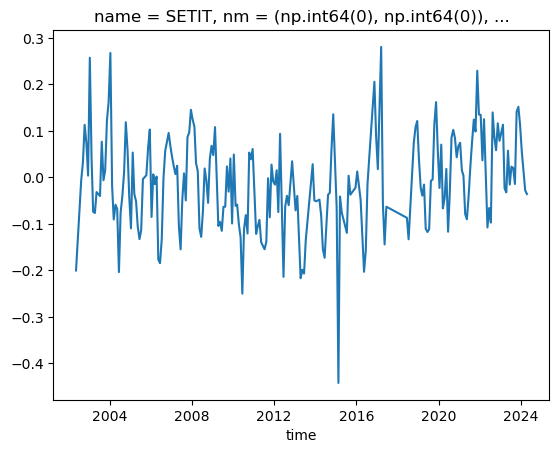

In [10]:
dsbasinav.sel(name="SETIT").plot()

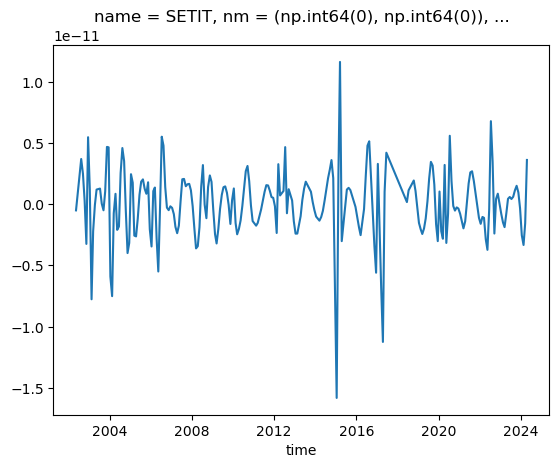

In [11]:
N=dsbasinav.time.dt.days_in_month
bsdsdt_month = bsdsdt*N*3600
bsdsdt_month.sel(name="SETIT").plot()

# Comparing with other methods

In [19]:
def tws_time_derivatives(dsbasinav,mean):

    if mean:
        dsbasinav=dsbasinav-dsbasinav.mean(dim="time")
    
    dt=dsbasinav.time.diff("time",label='upper')/np.timedelta64(1,"s")
    deltatws=dsbasinav.diff("time",label='upper')
    dsdt_backward=deltatws/dt
    dsdt_backward = dsdt_backward.reindex(time=dsbasinav.time)

    dsdt_derivatives=dsbasinav.differentiate(coord="time",edge_order=1,datetime_unit="s")

    dt_center=(dsbasinav.time.shift(time=-1)-dsbasinav.time.shift(time=1))/np.timedelta64(1,"s")
    dsdt_central=(dsbasinav.shift(time=-1)-dsbasinav.shift(time=1))/dt_center

    dsdtbasinav=dsbasinav.to_dataset(name="basinav")
    dsdtbasinav["dsdt_centerdiff"]=dsdt_central
    dsdtbasinav["dsdt_backwardsdiff"]=dsdt_backward
    dsdtbasinav["dsdt_differentiate"]=dsdt_derivatives

    return dsdtbasinav
    

In [20]:
dsdtbasinav=tws_time_derivatives(dsbasinav,mean=False)

In [21]:
dsdtbasinav["dsdt_bspline"]=bsdsdt

In [22]:
dsdtbasinav

<xarray.Dataset> Size: 1MB
Dimensions:             (name: 124, time: 230)
Coordinates:
  * name                (name) <U39 19kB 'SETIT' ... 'TIBETAN PLATEAU'
  * time                (time) datetime64[ns] 2kB 2002-05-15T12:00:00 ... 202...
    nm                  object 8B (np.int64(0), np.int64(0))
    n                   int64 8B 0
    m                   int64 8B 0
Data variables:
    basinav             (name, time) float64 228kB -0.2003 -0.006407 ... 0.03424
    dsdt_centerdiff     (name, time) float64 228kB nan 2.194e-08 ... nan
    dsdt_backwardsdiff  (name, time) float64 228kB nan 2.439e-08 ... -1.456e-08
    dsdt_differentiate  (name, time) float64 228kB 2.439e-08 ... -1.456e-08
    dsdt_bspline        (name, time) float64 228kB -4.409e-18 ... -1.024e-18

In [23]:
dsdtbasinav=dsdtbasinav.reset_coords(names=["n","m","nm"],drop=True)
dsdtbasinav=dsdtbasinav.assign_attrs(dsdt_units="m s**-1",basin_averages_unit="m")

In [24]:
dsdtbasinav

<xarray.Dataset> Size: 1MB
Dimensions:             (name: 124, time: 230)
Coordinates:
  * name                (name) <U39 19kB 'SETIT' ... 'TIBETAN PLATEAU'
  * time                (time) datetime64[ns] 2kB 2002-05-15T12:00:00 ... 202...
Data variables:
    basinav             (name, time) float64 228kB -0.2003 -0.006407 ... 0.03424
    dsdt_centerdiff     (name, time) float64 228kB nan 2.194e-08 ... nan
    dsdt_backwardsdiff  (name, time) float64 228kB nan 2.439e-08 ... -1.456e-08
    dsdt_differentiate  (name, time) float64 228kB 2.439e-08 ... -1.456e-08
    dsdt_bspline        (name, time) float64 228kB -4.409e-18 ... -1.024e-18
Attributes:
    dsdt_units:           m s**-1
    basin_averages_unit:  m

In [25]:
# save to netcdf for re-use

dsdtout=os.path.join(datadir,conf['dsdt'])
dsdtbasinav.to_netcdf(dsdtout)

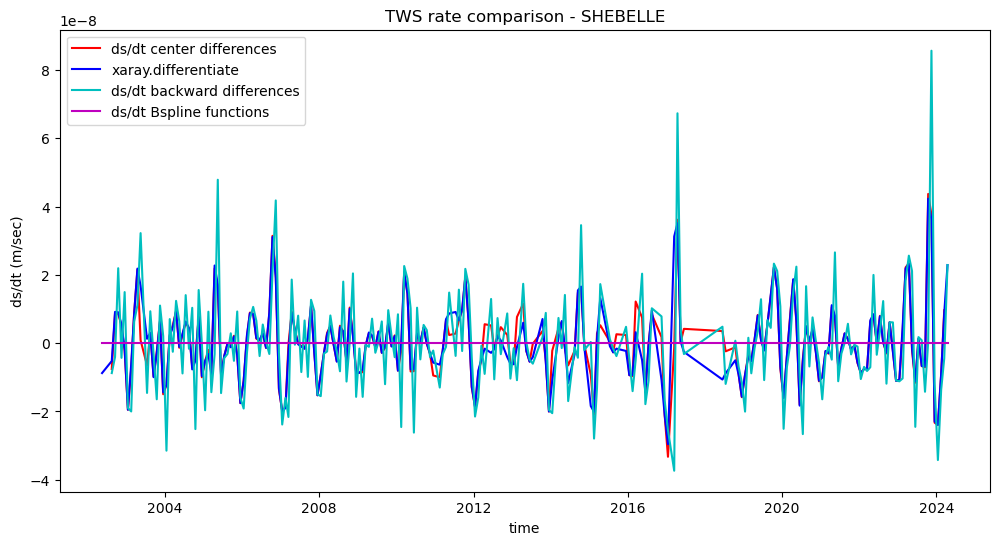

In [26]:
plt.figure(figsize=(12,6))

basinname="SHEBELLE"

plt.plot(dsdtbasinav.time,dsdtbasinav.dsdt_centerdiff.sel(name=basinname),label="ds/dt center differences",color="r")
plt.plot(dsdtbasinav.time,dsdtbasinav.dsdt_differentiate.sel(name=basinname),label="xaray.differentiate",color="b")
plt.plot(dsdtbasinav.time,dsdtbasinav.dsdt_backwardsdiff.sel(name=basinname),label="ds/dt backward differences",color="c")
plt.plot(dsdtbasinav.time,dsdtbasinav.dsdt_bspline.sel(name=basinname),label="ds/dt Bspline functions",color="m")

#name = dsbasinav.coords["name"].sel(name="SETIT").values
plt.title(f"TWS rate comparison - {basinname}")
plt.ylabel("ds/dt (m/sec)")
plt.xlabel("time")
plt.legend()


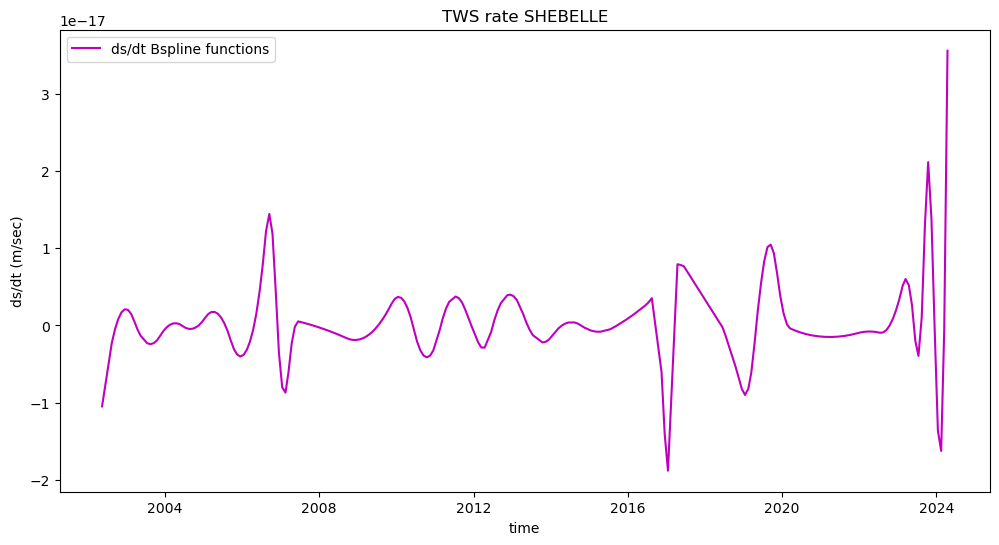

In [27]:
plt.figure(figsize=(12,6))

basinname="SHEBELLE"

plt.plot(dsdtbasinav.time,dsdtbasinav.dsdt_bspline.sel(name=basinname),label="ds/dt Bspline functions",color="m")

#name = dsbasinav.coords["name"].sel(name="SETIT").values
plt.title(f"TWS rate {basinname}")
plt.ylabel("ds/dt (m/sec)")
plt.xlabel("time")
plt.legend()